# RUBRIC@ TREC RAG 24


**RUBRIC evaluation result analysis**

### Augmentation Task


This notebook is part of the RUBRIC-trec-rag repository: 
<https://github.com/TREMA-UNH/rubric-trec-rag>

Data Files available from the Online Appendix:  <https://trec-car.cs.unh.edu/rubric-trec-rag24/index.html>

**Use via Colab, jupyter, or similar**

1. Open notebook from github repository
2. Uncomment and run the cell with
```
    !pip install exam-pp
    !pip install rubric-trec-rag
```
3. Run remaining cells in notebook


**Alternative: Use via Nix**

*Installation:*

1. check out the respository
2. install `nix` from <https://nixos.org/download/>  (not NixOS!)
3. follow instructions in repository [readme](https://github.com/TREMA-UNH/rubric-trec-rag/)

*Usage via Nix:*

4. configure python environment with dependencies by calling
```
    nix develop
```
5. start jupyter notebook server with
```
    jupyter notebook
```
6. open this notebook and run all cells

In [ ]:
#!pip install exam-pp
#!pip install rubric-trec-rag

In [1]:
import exam_pp
import rubric_trec_rag
from pathlib import Path
import numpy
import pandas as pd
import scipy

from exam_pp.exam_cover_metric import *
from scipy.stats._result_classes import TtestResult

from rubric_trec_rag.export_rag_gen_as_run import *
from exam_pp.exam_evaluation import *

[nltk_data] Downloading package stopwords to /home/dietz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/dietz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Device = None; BATCH_SIZE = 1


In [2]:
DATA=Path("./data")
promptclass="QuestionSelfRatedUnanswerablePromptWithChoices"

rubric_final_gen=DATA / "questions-rate--rubric-rag24-gen.jsonl.gz"
rubric_final_auggen=DATA / "questions-rate--rubric-rag24-auggen.jsonl.gz"
rubric_final_retrieval=DATA / "questions-rate--rubric-rag24-retrieval.jsonl.gz"

rubric_final = rubric_final_auggen


ungraded_base = plot_file = rubric_final.with_name(f"{rubric_final.stem}")

runs = rubric_final.with_name(f"{rubric_final.stem}-runs")
qrels = rubric_final.with_suffix(".qrel")
export_file = rubric_final.with_suffix(".export.tsv")
all_leaderboard_file = rubric_final.with_suffix(".leaderboard.tsv")
archive = rubric_final.with_suffix(".results.tar.gz")

runs, qrels, export_file, all_leaderboard_file, archive

(PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl-runs'),
 PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.qrel'),
 PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.export.tsv'),
 PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.leaderboard.tsv'),
 PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.results.tar.gz'))

In [3]:
rubric_final

PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.gz')

In [ ]:
# obtain rubric graded files
! mkdir -p {DATA}

!wget -nc https://trec-car.cs.unh.edu/rubric-trec-rag24/questions-rate--rubric-rag24-auggen.jsonl.gz -O {rubric_final_auggen}
!wget -nc https://trec-car.cs.unh.edu/rubric-trec-rag24/questions-rate--rubric-rag24-gen.jsonl.gz -O {rubric_final_gen}
!wget -nc https://trec-car.cs.unh.edu/rubric-trec-rag24/questions-rate--rubric-rag24-retrieval.jsonl.gz -O {rubric_final_retrieval}

File ‘{rubric_final_auggen}’ already there; not retrieving.
File ‘{rubric_final_gen}’ already there; not retrieving.


In [5]:
# num graded queries
!zcat {rubric_final} | wc -l

301


# Load Rubric data

In [6]:
def exam_grades(model, prompt_class, question_set, exam_graded_file):
    '''
    Load grades and paragraphs from RUBRIC internal file format
    '''
    grade_filter = GradeFilter(model_name=model, prompt_class = prompt_class, is_self_rated=None, min_self_rating=None, question_set=question_set, prompt_type=get_prompt_type_from_prompt_class(prompt_class))
    exam_input_file=exam_graded_file
    query_paragraphs:List[QueryWithFullParagraphList] = parseQueryWithFullParagraphs(exam_input_file)
    return query_paragraphs


# Open graded file and inspect exam grades

Json Example

```json
[
  "2024-145979",
  [
    {
      "paragraph_id": "b504cab1b522f7906c0abb44c30f4cd7",
      "text": "Vicarious trauma refers to the emotional and psychological impact experienced by individuals who are indirectly exposed to others' traumatic experiences.",
      "paragraph_data": {
        "judgments": [],
        "rankings": [
          {
            "method": "according-useful",
            "paragraphId": "b504cab1b522f7906c0abb44c30f4cd7",
            "queryId": "2024-145979",
            "rank": 1,
            "score": 1.0
          }
        ]
      },
      "exam_grades": [
        {
          "correctAnswered": [
            "2024-145979/ccc217319305b84a7a73db16d1d3d52d",
            "2024-145979/899180b0ca4b7daf548fc3b1d74c6917",
            "2024-145979/36b39eb1b546f06082fa99a07883a4ca",
            "2024-145979/06ff2a4f1e4869fe26dd034679403bad",
            "2024-145979/9b20f574516d894404136a8829b535d9",
            "2024-145979/dae1cd1ab183da5804311e764b1987d0",
            "2024-145979/bd8cc33b944bc940b9ed6a49c0f4502a",
            "2024-145979/40ee972ed1298a8b6e4894467c1a9dc4",
            "2024-145979/c8271d09bfd0b289d93ea501b129f308"
          ],
          "wrongAnswered": [
            "2024-145979/87c4cb0bd3430af2fc39ee05959e6abb"
          ],
          "answers": [
            [
              "2024-145979/ccc217319305b84a7a73db16d1d3d52d",
              "5\nExplanation: The passage provides a clear and comprehensive overview of vicarious trauma, including common symptoms such as emotional exhaustion, detachment, and cynicism. The passage also explains the potential long-term effects of
 vicarious trauma on individuals, making it a highly relevant and accurate answer to the question."
            ],
            [
              "2024-145979/899180b0ca4b7daf548fc3b1d74c6917",
              "5\nExplanation: The passage provides a clear and accurate definition of vicarious trauma, which is distinct from burnout. It explains that vicarious trauma is the emotional and psychological impact experienced by individuals who are in
directly exposed to others' traumatic experiences. This answer is highly relevant, complete, and accurate, as it directly addresses the question and provides a clear distinction between vicarious trauma and burnout."
            ],
            [
              "2024-145979/87c4cb0bd3430af2fc39ee05959e6abb",
              "The passage does not directly address the question, but it does provide some relevant information about vicarious trauma and its effects. The passage does not provide specific coping strategies for dealing with vicarious trauma. Howeve
r, it does suggest that it is important to recognize the impact of vicarious trauma and to seek support when needed. The passage also mentions that vicarious trauma can be mitigated by developing a sense of control and by engaging in activities that 
promote a sense of well-being. Overall, the passage provides some"
            ],
            [
              "2024-145979/36b39eb1b546f06082fa99a07883a4ca",
              "5. The passage directly addresses the impact of vicarious trauma on personal relationships outside of work, providing a clear and accurate answer to the question. It highlights the potential for vicarious trauma to affect relationships with family and friends, as well as the importance of self-care and support networks in mitigating its effects. The passage provides a comprehensive and relevant answer to the question."
            ],
            [
              "2024-145979/06ff2a4f1e4869fe26dd034679403bad",
              "5\nExplanation: The passage clearly states that professional therapy or counseling is usually recommended for those experiencing vicarious trauma, as it can help them process and cope with their emotions. The passage also mentions that vicarious trauma can have long-lasting effects if left untreated. The answer is highly relevant, complete, and accurate, earning a rating of 5."
            ],
            [
              "2024-145979/9b20f574516d894404136a8829b535d9",
              "4\nExplanation: The passage provides some relevant information about vicarious trauma, such as its definition and the potential effects on individuals. However, it does not offer specific strategies or recommendations for organizations to better support individuals who may be experiencing vicarious trauma. Therefore, the answer is mostly relevant and complete but may have minor gaps or inaccuracies."
            ],
            [
              "2024-145979/dae1cd1ab183da5804311e764b1987d0",
              "4\nExplanation: The passage discusses the importance of self-care for individuals who have been exposed to others' traumatic experiences, but it does not provide a comprehensive overview of the role of self-care in coping with vicarious trauma. It mentions that self-care can help individuals develop resilience and reduce the risk of burnout, but it does not elaborate on the specific ways in which self-care can be used to cope with vicarious trauma. The passage also does not provide any concrete examples or strategies for incorporating"
            ],
            [
              "2024-145979/bd8cc33b944bc940b9ed6a49c0f4502a",
              "4\nExplanation: The passage does not directly answer the question, but it provides some relevant information about the concept of vicarious trauma and its effects. It mentions that vicarious trauma can occur in various settings, including healthcare, social services, and education. However, it does not specifically mention industries or professions that are more prone to vicarious trauma. Therefore, the answer is rated as 4, indicating that the passage is mostly relevant and complete but lacks specific information on the topic."
            ],
            [
              "2024-145979/40ee972ed1298a8b6e4894467c1a9dc4",
              "4. The passage provides a general understanding of vicarious trauma and its impact, but it does not specifically address how individuals can identify their own triggers for vicarious trauma. The reader would need to look elsewhere for more detailed information on this topic. However, the passage does provide a good foundation for understanding the concept of vicarious trauma, which is a good starting point for further exploration."
            ],
            [
              "2024-145979/c8271d09bfd0b289d93ea501b129f308",
              "5\nExplanation: The passage provides a comprehensive overview of resources available for preventing and managing vicarious trauma in the workplace. It highlights the importance of creating a supportive work environment, providing training and education, and encouraging open communication. The passage also mentions the role of leadership and management in addressing vicarious trauma, as well as the need for ongoing support and resources for affected employees. Overall, the passage provides a thorough and accurate answer to the question."
            ]
          ],
          "llm": "meta-llama/Meta-Llama-3-8B-Instruct",
          "llm_options": {},
          "exam_ratio": 0.9,
          "prompt_info": {
            "prompt_class": "QuestionSelfRatedUnanswerablePromptWithChoices",
            "orig_prompt_class": "unknown",
            "prompt_style": "Can the question be answered based on the available context? Choose one",
            "context_first": false,
            "check_unanswerable": true,
            "check_answer_key": false,
            "is_self_rated": true,
            "is_self_rater_tolerant": true
          },
           "self_ratings": [
            {
              "question_id": "2024-145979/ccc217319305b84a7a73db16d1d3d52d",
              "self_rating": 5
            },
            {
              "question_id": "2024-145979/899180b0ca4b7daf548fc3b1d74c6917",
              "self_rating": 5
            },
            {
              "question_id": "2024-145979/87c4cb0bd3430af2fc39ee05959e6abb",
              "self_rating": 0
            },
            {
              "question_id": "2024-145979/36b39eb1b546f06082fa99a07883a4ca",
              "self_rating": 5
            },
            {
              "question_id": "2024-145979/06ff2a4f1e4869fe26dd034679403bad",
              "self_rating": 5
            },
            {
              "question_id": "2024-145979/9b20f574516d894404136a8829b535d9",
              "self_rating": 4
            },
            {
              "question_id": "2024-145979/dae1cd1ab183da5804311e764b1987d0",
              "self_rating": 4
            },
            {
              "question_id": "2024-145979/bd8cc33b944bc940b9ed6a49c0f4502a",
              "self_rating": 4
            },
            {
              "question_id": "2024-145979/40ee972ed1298a8b6e4894467c1a9dc4",
              "self_rating": 4
            },
            {
              "question_id": "2024-145979/c8271d09bfd0b289d93ea501b129f308",
              "self_rating": 5
            }
          ],
          "prompt_type": "question"
        }
      ]
    },

```

In [7]:
print(f"rubric file: {rubric_final}")
# load grades from rubric file
examgrades = exam_grades(model=None, prompt_class=promptclass, question_set="question-bank", exam_graded_file=rubric_final)

rubric file: data/questions-rate--rubric-rag24-auggen.jsonl.gz


In [8]:
# example for inspecting RUBRIC grading results

for result in examgrades[0:1]: # just first query
    result: QueryWithFullParagraphList
    queryId=result.queryId
    paragraphs=result.paragraphs
    print(f"query = {result.queryId}")

    for paragraph in paragraphs[0:10]:  # just first ten paragraphs
        paragraph: FullParagraphData
        paragraph_id = paragraph.paragraph_id
        text = paragraph.text
        # judgments = paragraph.paragraph_data.judgments if paragraph.paragraph_data else []  # manual judgments currently not available for RAG
        rankings = paragraph.paragraph_data.rankings if paragraph.paragraph_data else [] # which system retrieved this paragraph?
        print("\n")
        print(paragraph_id)
        print(text)
        print(rankings)
        for grades in paragraph.exam_grades:
            grades: ExamGrades
            # self_ratings are the numerical grade (0-5) for each question-style nugget
            # answers are the raw output we received from the grading LLM
            for (r, a) in zip(grades.self_ratings, grades.answers): 
                print(r.question_id, r.self_rating, 'raw_answer: ',a)

query = 2024-105741


072fa5f55026f2f9edaf7b7692eb2e24
A white blood cell count (WBC) over 15,000 without treatment is not necessarily dangerous in itself, but it can be a sign of an underlying infection or inflammation that requires medical attention. 
[ParagraphRankingEntry(method='agricultural-cloth', paragraphId='072fa5f55026f2f9edaf7b7692eb2e24', queryId='2024-105741', rank=1, score=1.0)]
2024-105741/c34c185a1c2e904c79a595c7b5129d5d 0 raw_answer:  ('2024-105741/c34c185a1c2e904c79a595c7b5129d5d', '0')
2024-105741/173d9effb9b6d9c96d91e943c648546a 0 raw_answer:  ('2024-105741/173d9effb9b6d9c96d91e943c648546a', '0')
2024-105741/853e1e2f8d5c27ccfe67a8437abc7cd0 4 raw_answer:  ('2024-105741/853e1e2f8d5c27ccfe67a8437abc7cd0', '4')
2024-105741/35d6b5c48e177b44e55e725d4f27594b 0 raw_answer:  ('2024-105741/35d6b5c48e177b44e55e725d4f27594b', '0')
2024-105741/1144385a494fa940216cf0309c880af1 0 raw_answer:  ('2024-105741/1144385a494fa940216cf0309c880af1', '0')
2024-105741/ea5e716f83b86509f60a1

In [9]:
# rubric  json schema
print("queryId, list of...")

print(FullParagraphData.schema_json(indent=2))

queryId, list of...
{
  "title": "FullParagraphData",
  "type": "object",
  "properties": {
    "paragraph_id": {
      "title": "Paragraph Id",
      "type": "string"
    },
    "text": {
      "title": "Text",
      "type": "string"
    },
    "paragraph": {
      "title": "Paragraph"
    },
    "paragraph_data": {
      "$ref": "#/definitions/ParagraphData"
    },
    "exam_grades": {
      "title": "Exam Grades",
      "type": "array",
      "items": {
        "$ref": "#/definitions/ExamGrades"
      }
    },
    "grades": {
      "title": "Grades",
      "type": "array",
      "items": {
        "$ref": "#/definitions/Grades"
      }
    }
  },
  "required": [
    "paragraph_id",
    "text",
    "paragraph_data"
  ],
  "definitions": {
    "Judgment": {
      "title": "Judgment",
      "type": "object",
      "properties": {
        "paragraphId": {
          "title": "Paragraphid",
          "type": "string"
        },
        "query": {
          "title": "Query",
          "typ

# Extract leaderboards


RUBRIC-cover:
1. run `export_rag_rubric_cover_leaderboard`


RUBRIC-qrels:
1. convert run files from rubric files  (`export_rag_gen_as_run_main`)
2. produce leaderboard with trec_eval


Manual production of RUBRIC-qrels
1. convert run files from rubric files (`export_rag_gen_as_run_main`)
2. export qrels file  (`export_qrels`)
3. run trec_eval (or similar) manually 


### Convert run files

(this may take a moment)

In [10]:
def export_rag_gen_as_run_main(rubric_graded_file, run_out):
    # now emit the input files for RUBRIC/EXAM
    rubric_data:List[QueryWithFullParagraphList] 
    # rubric_data = parseQueryWithFullParagraphs(rubric_graded_file)
    rubric_data = examgrades

    run_entry_per_method:Dict[str,List[ParagraphRankingEntry]] = defaultdict(list)

    # collect ranking entries
    for entry in rubric_data:
        for para in entry.paragraphs:
            for rankEntry in para.paragraph_data.rankings:
                run_entry_per_method[rankEntry.method].append(rankEntry)

    runDir:Path = run_out
    
    # create dir if necessary
    runDir.mkdir(exist_ok=True)
    
    # delete old files
    for file in runDir.iterdir():
        if file.is_file():
            file.unlink()

    # write as trec_eval compatible run files
    for method,rankEntries in run_entry_per_method.items():
        sorted_ranking_entries = sorted(rankEntries, key=attrgetter('queryId','rank'))
        unique_sorted_ranking_entries = remove_duplicates_by_key(sorted_ranking_entries, key_func=lambda r: (r.queryId, r.paragraphId))
        
        runFile = runDir/(f'{method}.run')
        if(runFile.exists()):
            print(f"Overwriting {runFile.absolute()}")
        else: 
            print(f"Exporting to {runFile.absolute()}")
        export_run_file(run_file=runFile, ranking_entries=unique_sorted_ranking_entries)

    return unique_sorted_ranking_entries 

In [11]:
res = export_rag_gen_as_run_main(rubric_final, runs)
res[0:10]

Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-auggen.jsonl-runs/agricultural-cloth.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-auggen.jsonl-runs/alive-start.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-auggen.jsonl-runs/flavor-case.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-auggen.jsonl-runs/ally-what.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-auggen.jsonl-runs/alter-stir.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-auggen.jsonl-runs/plant-taxpayer.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-auggen.jsonl-runs/angle-heel.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-auggen.jsonl-runs/headquarte

[ParagraphRankingEntry(method='zero-relax', paragraphId='2c4f1db7da7fd43e0478dfa0690ac35e', queryId='2024-105741', rank=1, score=1.0),
 ParagraphRankingEntry(method='zero-relax', paragraphId='c4022e12facb3529d4a3d9cbe5a97979', queryId='2024-105741', rank=2, score=0.5),
 ParagraphRankingEntry(method='zero-relax', paragraphId='7f07a375769de74f5ccb4a09ee62f619', queryId='2024-105741', rank=3, score=0.3333333333333333),
 ParagraphRankingEntry(method='zero-relax', paragraphId='4f9c186f44c9af6ee5b0252b17c57c22', queryId='2024-105741', rank=4, score=0.25),
 ParagraphRankingEntry(method='zero-relax', paragraphId='d142d8f23bdf34fdd4139b53643cd674', queryId='2024-105741', rank=5, score=0.2),
 ParagraphRankingEntry(method='zero-relax', paragraphId='f8cfb9328539eecf755862dd22f2794a', queryId='2024-105741', rank=6, score=0.16666666666666666),
 ParagraphRankingEntry(method='zero-relax', paragraphId='3bf93479ce4fafc1399ea71d8ddf2fee', queryId='2024-105741', rank=7, score=0.14285714285714285),
 Paragr

# Export Leaderboard

In [12]:
# If multiple grading configuration are in the same rubric file, 
# then use this grade filter to select a particular LLM model (e.g. "google/flan-t5-large")
# or grading prompt (e.g. "QuestionSelfRatedUnanswerablePromptWithChoices" or "NuggetSelfRatedPrompt")
# or question set (e.g. "question-bank")
# or prompt_type (e.g "question", "nugget", or "direct")

grade_filter = GradeFilter(model_name=None, prompt_class = promptclass, is_self_rated=None, min_self_rating=None, question_set="question-bank", prompt_type=get_prompt_type_from_prompt_class(promptclass))

## Export qrels for RUBRIC-Qrels or manual trec_eval

In [13]:
# function to export qrels
def export_qrels(examgrades, qrel_out, prompt_class, model):
    grade_filter = GradeFilter(model_name=model, prompt_class = prompt_class, is_self_rated=None, min_self_rating=None, question_set="question-bank", prompt_type=get_prompt_type_from_prompt_class(prompt_class))

    exam_pp.exam_evaluation.export_qrels(query_paragraphs=examgrades
             , qrel_out_file=qrel_out
             , grade_filter=grade_filter
             , use_query_facets=False
             , use_ratings=True  # answerability grades
             , direct_grading=False
             )


In [14]:
# perform export
export_qrels(examgrades, qrels, promptclass,model=None)


In [15]:
# Verify exported qrel content

!head {qrels}

2024-105741 0 072fa5f55026f2f9edaf7b7692eb2e24 4
2024-105741 0 33b2fe5e24140b33aaa8c15877130ff7 4
2024-105741 0 d5c1227eb98ec7562e7ff0a57cf4e758 3
2024-105741 0 169346ef5b43e5b1e0df88f80f44b9b4 2
2024-105741 0 b5bc8f133cb40d8db3664ce0a51480a9 3
2024-105741 0 3924e17a07c750b03286494b74fd3e4f 2
2024-105741 0 71d56862b0c09cd8eaa748232d930f9d 4
2024-105741 0 d657b24d71a620e3d31d45a919bd4b6d 1
2024-105741 0 755918dab53db3fc1c21a1f5dde43715 2
2024-105741 0 eed5982462ca5ab5e665411f5fd84dd5 0


## Export individual RUBRIC leaderboards

You can skip forward to the next section, if you don't want to create additional leaderboards.

In [16]:
minrating = 4

cover_board= rubric_final.with_name(f"{rubric_final.stem}-cover-{minrating}").with_suffix(".tsv")
qrels_board= rubric_final.with_name(f"{rubric_final.stem}-qrels-{minrating}").with_suffix(".tsv")

In [17]:
# functions to export a RUBRIC-Cover Leaderboard

# Alternatives to produce leaderboard
# python -O -m exam_pp.exam_evaluation $DATA/$rubric_final --question-set question-bank --prompt-class $promptclass --min-self-rating $minrating --leaderboard-out $DATA/$cover_board.tsv

# exam_pp.exam_evaluation.run_leaderboard(leaderboard_file=cover_board
#                         , grade_filter=grade_filter
#                         , query_paragraphs=examgrades
#                         , min_self_rating=minrating
#                         , leaderboard_sort=None
#                         )


def cover_leaderboard(leaderboard_file, examgrades, minrating, leaderboard_sort:Optional[str])-> Dict[str,exam_pp.exam_cover_metric.ExamCoverEvalsDict]:
    '''
    Computes query-wise RUBRIC-cover score
    writes a tsv file with mean and stderr to `leaderboard_file`
    returns a dictionary of MethodName to `ExamCoverEvalsDict`
    '''
    exam_factory = ExamCoverScorerFactory(grade_filter=grade_filter, min_self_rating=minrating)
    resultsPerMethod:Dict[str, ExamCoverEvals] = compute_exam_cover_scores(examgrades, exam_factory=exam_factory)
    export_leaderboard_table(leaderboard_out=leaderboard_file, evals= list(resultsPerMethod.values()), sortBy=leaderboard_sort)
    return resultsPerMethod

In [18]:
# function to export a RUBRIC-qrels leaderboard
from exam_pp.exam_run_trec_eval import *

def qrels_leaderboard(leaderboard_file, run_dir, qrels,  examgrades, minrating, trec_eval_metric, leaderboard_sort:Optional[str])-> Dict[str,exam_pp.exam_cover_metric.ExamCoverEvalsDict]:
    resultsPerMethod:Dict[str, ExamCoverEvals]
    
    trec_eval_out =run_trec_eval_variance(run_dir=run_dir, qrels=qrels, min_level=minrating, trec_eval_metric=trec_eval_metric)
    trec_eval_parsed=parse_trec_eval_variance(trec_eval_out)
    resultsPerMethod = compute_exam_qrels_scores(trec_eval_parsed)
    
    # exam_leaderboard_correlation.print_leaderboard_eval(evals = list(resultsPerMethod.values()), grade_filter=grade_filter)
    export_leaderboard_table(leaderboard_out=leaderboard_file, evals= list(resultsPerMethod.values()), sortBy=leaderboard_sort)
    return resultsPerMethod

In [19]:
# Because TREC RAG segment Ids contain `#`
# which is considered a reserved comment char in trec_eval, 
# we have to patch all generated run/qrel files to get rid of it.

import subprocess

print(runs)
subprocess.run(["find", runs, "-type", "f", "-exec", "sed", "-i", "s/#//g", "{}", "+"])

print(qrels)
subprocess.run(["sed", "-i", "s/#//g", qrels])

data/questions-rate--rubric-rag24-auggen.jsonl-runs
data/questions-rate--rubric-rag24-auggen.jsonl.qrel


CompletedProcess(args=['sed', '-i', 's/#//g', PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.qrel')], returncode=0)

In [20]:
# example of individual leaderboards

# cover_result = cover_leaderboard(leaderboard_file=cover_board, examgrades=examgrades,minrating= minrating, leaderboard_sort=None)
qrel_result = qrels_leaderboard(leaderboard_file=qrels_board, run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= minrating, trec_eval_metric="P.20"
                                , leaderboard_sort=None)

Running trec_eval command:
for f in *.run; do  res=`trec_eval -n -c -q -m P.20  -l 4  /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-auggen.jsonl.qrel $f`; echo "$f $res"; done
in directory: data/questions-rate--rubric-rag24-auggen.jsonl-runs
OVERALL EXAM-qrels method _overall_: avg examScores 0.00 +/0 0.000
OVERALL EXAM-qrels method agricultural-cloth: avg examScores 0.19 +/0 0.008
OVERALL EXAM-qrels method alive-start: avg examScores 0.18 +/0 0.008
OVERALL EXAM-qrels method ally-what: avg examScores 0.20 +/0 0.009
OVERALL EXAM-qrels method alter-stir: avg examScores 0.28 +/0 0.011
OVERALL EXAM-qrels method angle-heel: avg examScores 0.30 +/0 0.008
OVERALL EXAM-qrels method blame-governor: avg examScores 0.07 +/0 0.004
OVERALL EXAM-qrels method brush-plot: avg examScores 0.10 +/0 0.004
OVERALL EXAM-qrels method colour-sake: avg examScores 0.26 +/0 0.007
OVERALL EXAM-qrels method cooperation-rapid: avg examScores 0.14 +/0 0.007
OVERALL EXAM-qrels method c

In [21]:
# Verify RUBRIC-qrels leaderboard output
!cat {qrels_board}

method	ExamCover	+/-	std-err
_overall_	0.000	+/-	0.000
agricultural-cloth	0.190	+/-	0.008
alive-start	0.179	+/-	0.008
ally-what	0.198	+/-	0.009
alter-stir	0.277	+/-	0.011
angle-heel	0.295	+/-	0.008
blame-governor	0.070	+/-	0.004
brush-plot	0.104	+/-	0.004
colour-sake	0.262	+/-	0.007
cooperation-rapid	0.144	+/-	0.007
corporation-heel	0.119	+/-	0.006
creature-contemporary	0.230	+/-	0.006
custom-belong	0.351	+/-	0.011
desire-originally	0.073	+/-	0.004
electronic-explain	0.155	+/-	0.005
engine-lifestyle	0.088	+/-	0.003
example-newspaper	0.102	+/-	0.004
flag-satellite	0.195	+/-	0.009
flavor-case	0.078	+/-	0.004
freeze-park	0.287	+/-	0.007
gene-chest	0.269	+/-	0.007
group-herself	0.127	+/-	0.003
headquarters-poem	0.528	+/-	0.017
include-signal	0.264	+/-	0.007
information-knee	0.143	+/-	0.005
instead-council	0.255	+/-	0.007
language-practical	0.448	+/-	0.012
look-print	0.110	+/-	0.004
love-volunteer	0.203	+/-	0.006
medication-pause	0.140	+/-	0.007
medium-custom	0.283	+/-	0.007
morning-monkey	

In [22]:
# example of computing mean +/- stderr per method

from exam_pp.exam_cover_metric import *
from scipy.stats._result_classes import TtestResult

def leaderboard_mean_stderr(leaderboard, method):
    '''
    Mean and stderr of a method (=system/run) under a RUBRIC-measure
    '''
    mean,stderr=systemMeanStderr(leaderboard[method].examCoverPerQuery.values())
    return mean,stderr

@dataclass
class ComparisonResult():
    mean1:float
    mean2:float
    ttest_result:TtestResult
    mean_diff:float

def leaderboard_paired_ttest(leaderboard, method1, method2):
    '''
    Are two methods (=systems/runs) significantly different under a RUBRIC-measure?
    '''
    values1 = numpy.array(list(leaderboard[method1].examCoverPerQuery.values()))
    values2 = numpy.array(list(leaderboard[method2].examCoverPerQuery.values()))

    mean1 = numpy.mean(values1)
    mean2 = numpy.mean(values2)
    t = scipy.stats.ttest_rel(values1, values2)
    mean_diff = numpy.mean(values1 - values2)

    return ComparisonResult(mean1=mean1, mean2=mean2, ttest_result=t,  mean_diff=mean_diff)

In [23]:
# example on how to access results and compute statistics

leader_result = qrel_result
# leader_result = cover_result

print(leader_result.keys())

method1 = list(leader_result.keys())[1] # 'space-traffic'
method2 = list(leader_result.keys())[7] #'pepper-highlight'

mean1,stderr1=leaderboard_mean_stderr(leader_result, method1)
mean2,stderr2=leaderboard_mean_stderr(leader_result, method2)
comparison=leaderboard_paired_ttest(leader_result, method1, method2)

print(f"{method1}: {mean1} +/- {stderr1}")
print(f"{method2}: {mean2} +/- {stderr2}")
print(f"{method1}: {comparison.mean1}   vs {method2}:{comparison.mean2}")
print(f"avg 1 better? {comparison.mean_diff}")
print(f"paired ttest: {comparison.ttest_result}")

dict_keys(['_overall_', 'agricultural-cloth', 'alive-start', 'ally-what', 'alter-stir', 'angle-heel', 'blame-governor', 'brush-plot', 'colour-sake', 'cooperation-rapid', 'corporation-heel', 'creature-contemporary', 'custom-belong', 'desire-originally', 'electronic-explain', 'engine-lifestyle', 'example-newspaper', 'flag-satellite', 'flavor-case', 'freeze-park', 'gene-chest', 'group-herself', 'headquarters-poem', 'include-signal', 'information-knee', 'instead-council', 'language-practical', 'look-print', 'love-volunteer', 'medication-pause', 'medium-custom', 'morning-monkey', 'naturally-best', 'nature-mixture', 'nearly-tired', 'neighborhood-enjoy', 'origin-sail', 'perfectly-solar', 'plant-taxpayer', 'raise-earnings', 'rose-manager', 'social-defensive', 'southern-favorite', 'steam-democratic', 'step-monitor', 'sweet-health', 'teen-gently', 'terror-shall', 'trial-seek', 'view-technique', 'virus-rush', 'welfare-conversation', 'writing-shift', 'zero-relax'])
agricultural-cloth: 0.1901666666

## Compute TREC RAG Leaderboards

We are computing five RUBRIC-leaderboards which we contribute in the TREC RAG'24 Evaluatuation

In [24]:
cover_result1 = cover_leaderboard(leaderboard_file=rubric_final.with_suffix(".cover-1.tsv"), examgrades=examgrades,minrating= 1, leaderboard_sort=None)
cover_result4 = cover_leaderboard(leaderboard_file=rubric_final.with_suffix(".cover-4.tsv"), examgrades=examgrades,minrating= 4, leaderboard_sort=None)
cover_result5 = cover_leaderboard(leaderboard_file=rubric_final.with_suffix(".cover-5.tsv"), examgrades=examgrades,minrating= 5, leaderboard_sort=None)

qrel_result_ndcg = qrels_leaderboard(leaderboard_file=rubric_final.with_suffix(".qrels-ndcg.tsv"), run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= 1, trec_eval_metric="ndcg_cut.20"
                                , leaderboard_sort=None)
qrel_result1 = qrels_leaderboard(leaderboard_file=rubric_final.with_suffix(".qrels-1.tsv"), run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= 1, trec_eval_metric="P.20"
                                , leaderboard_sort=None)
qrel_result4 = qrels_leaderboard(leaderboard_file=rubric_final.with_suffix(".qrels-4.tsv"), run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= 4, trec_eval_metric="P.20"
                                , leaderboard_sort=None)
qrel_result5 = qrels_leaderboard(leaderboard_file=rubric_final.with_suffix(".qrels-5.tsv"), run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= 5, trec_eval_metric="P.20"
                                , leaderboard_sort=None)

2024-105741, overall ratio 1.0
2024-109837, overall ratio 1.0
2024-111331, overall ratio 0.9
2024-111506, overall ratio 1.0
2024-113215, overall ratio 1.0
2024-113646, overall ratio 1.0
2024-114095, overall ratio 1.0
2024-121840, overall ratio 1.0
2024-126056, overall ratio 1.0
2024-126326, overall ratio 1.0
2024-126414, overall ratio 1.0
2024-127266, overall ratio 1.0
2024-127288, overall ratio 1.0
2024-127349, overall ratio 1.0
2024-127653, overall ratio 0.9
2024-128311, overall ratio 1.0
2024-12875, overall ratio 1.0
2024-128784, overall ratio 1.0
2024-129062, overall ratio 1.0
2024-129925, overall ratio 1.0
2024-131116, overall ratio 1.0
2024-133137, overall ratio 1.0
2024-133810, overall ratio 1.0
2024-134629, overall ratio 1.0
2024-134815, overall ratio 1.0
2024-134964, overall ratio 1.0
2024-135747, overall ratio 1.0
2024-136156, overall ratio 1.0
2024-137182, overall ratio 1.0
2024-137315, overall ratio 1.0
2024-137667, overall ratio 1.0
2024-138052, overall ratio 1.0
2024-1412

In [25]:
# collect leaderboards from different RUBRIC measures

boards={"cover-1": cover_result1
    , "cover-4": cover_result4
    , "cover-5": cover_result5
    , "qrels-ndcg": qrel_result_ndcg
    , "qrels-1": qrel_result1
    , "qrels-4": qrel_result4
    , "qrels-5": qrel_result5
}

In [26]:
# Export system evaluation scores per system/query/measure

@dataclass
class RunMeasureTopicValue():
    run:str
    measure:str
    topic:str
    value:float

# function to run the export
def export_method_measure_topic_value_format(boards:Dict[str, ExamCoverEvals]):
    export_lines = list()
    for measure, cover_evals_dict in boards.items():
        for method, cover_evals in cover_evals_dict.items():
            lines = [RunMeasureTopicValue(run=cover_evals.method, measure=measure, topic=topic, value=v) 
                         for topic, v in cover_evals.examCoverPerQuery.items()
                         # if cover_evals.method != "_overall_"
                   ]
            export_lines.extend(lines)
    return export_lines

# perform export
lines = export_method_measure_topic_value_format(boards)
with open(export_file, "wt") as file:
    file.write("\n".join( [ f"{line.run}\t{line.measure}\t{line.topic}\t{line.value}" for line in lines]))
    file.flush()

# example output
lines[0:10000:300]

[RunMeasureTopicValue(run='_overall_', measure='cover-1', topic='2024-105741', value=1.0),
 RunMeasureTopicValue(run='_overall_', measure='cover-1', topic='2024-96485', value=0.9),
 RunMeasureTopicValue(run='agricultural-cloth', measure='cover-1', topic='2024-96485', value=0.6),
 RunMeasureTopicValue(run='alive-start', measure='cover-1', topic='2024-96359', value=0.0),
 RunMeasureTopicValue(run='flavor-case', measure='cover-1', topic='2024-96063', value=0.7),
 RunMeasureTopicValue(run='ally-what', measure='cover-1', topic='2024-96063', value=1.0),
 RunMeasureTopicValue(run='alter-stir', measure='cover-1', topic='2024-94706', value=0.7),
 RunMeasureTopicValue(run='plant-taxpayer', measure='cover-1', topic='2024-90454', value=0.2),
 RunMeasureTopicValue(run='angle-heel', measure='cover-1', topic='2024-88894', value=0.4),
 RunMeasureTopicValue(run='headquarters-poem', measure='cover-1', topic='2024-79154', value=0.9),
 RunMeasureTopicValue(run='view-technique', measure='cover-1', topic='2

## Leaderboard Plotting code

In [27]:
import pandas as pd
def leaderboard_to_dataframe(leaderboard):
    out = [(method, mean, stderr)
       for method in leaderboard.keys() if method != "_overall_"
       for mean, stderr in [leaderboard_mean_stderr(leaderboard, method)]
      ]
    return pd.DataFrame(out, columns=['method', 'mean', 'stderr']).set_index('method')

def join_leaderboards(boards: Dict[str,pd.DataFrame], sort_by_board:str):
    data = pd.concat(boards, names=['evals'], axis=1)
    data = data.swaplevel(0,1, axis=1)
    data = data.sort_values(by=("mean",sort_by_board), ascending=False)
    return data

In [28]:
# convert leaderboards to pandas data frames

df_boards={key:leaderboard_to_dataframe(val) for key,val in boards.items()}
leaderboard_df = join_leaderboards(df_boards, sort_by_board="qrels-ndcg")
leaderboard_df_cover = join_leaderboards(df_boards, sort_by_board="cover-4")

In [29]:
# export as TSV
leaderboard_df.to_csv(all_leaderboard_file, sep='\t', index=True)

leaderboard_df

,mean,stderr,mean,stderr,mean,stderr,mean,stderr,mean,stderr,mean,stderr,mean,stderr
evals,cover-1,cover-1,cover-4,cover-4,cover-5,cover-5,qrels-ndcg,qrels-ndcg,qrels-1,qrels-1,qrels-4,qrels-4,qrels-5,qrels-5
method,,,,,,,,,,,,,,
rose-manager,0.853061,0.009196,0.708084,0.013310,0.246182,0.015001,0.822635,0.007589,0.948333,0.005373,0.820167,0.012354,0.296500,0.019169
headquarters-poem,0.744891,0.012693,0.545552,0.016165,0.145847,0.012248,0.611274,0.011952,0.745847,0.013523,0.527575,0.016765,0.122259,0.011042
language-practical,0.820101,0.009620,0.660448,0.014024,0.181395,0.013251,0.553612,0.008687,0.587708,0.010484,0.447674,0.012081,0.123090,0.009859
nature-mixture,0.813789,0.009777,0.656905,0.014300,0.186318,0.013166,0.547042,0.008652,0.577741,0.010768,0.436379,0.011760,0.120432,0.009475
neighborhood-enjoy,0.838931,0.009468,0.729622,0.012924,0.215162,0.014754,0.488661,0.005857,0.391860,0.006416,0.359801,0.006737,0.141196,0.009356
raise-earnings,0.723363,0.012603,0.512410,0.015688,0.115282,0.010880,0.484148,0.009739,0.566777,0.009308,0.370598,0.012348,0.082890,0.007955
naturally-best,0.721605,0.012533,0.506319,0.015721,0.116611,0.010363,0.483207,0.009668,0.563123,0.009150,0.369934,0.012068,0.084053,0.008062
custom-belong,0.737286,0.012637,0.548126,0.015781,0.129206,0.011795,0.477039,0.009422,0.523588,0.010092,0.351329,0.011421,0.076744,0.007338


In [30]:
# Compute Min/Max/Med and inter-quartile ranges

quantiles = leaderboard_df.quantile([0.0,0.25, 0.5,0.75,0.85,1.0])

quantiles

,mean,stderr,mean,stderr,mean,stderr,mean,stderr,mean,stderr,mean,stderr,mean,stderr
evals,cover-1,cover-1,cover-4,cover-4,cover-5,cover-5,qrels-ndcg,qrels-ndcg,qrels-1,qrels-1,qrels-4,qrels-4,qrels-5,qrels-5
0.00,0.406755,0.009196,0.203987,0.012924,0.031229,0.005205,0.156133,0.002689,0.088040,0.001542,0.070266,0.002593,0.012292,0.001711
0.25,0.610192,0.011552,0.391634,0.014886,0.081728,0.008823,0.233964,0.005243,0.176333,0.005247,0.120500,0.005124,0.028261,0.002947
0.50,0.680569,0.013053,0.460713,0.015667,0.109000,0.010783,0.318659,0.006352,0.280667,0.006209,0.198167,0.006737,0.047333,0.004497
0.75,0.759871,0.014591,0.568663,0.016183,0.143303,0.012214,0.415652,0.007765,0.370432,0.009150,0.283167,0.008452,0.070598,0.006059
0.85,0.771215,0.014788,0.583230,0.016294,0.148626,0.012378,0.446011,0.008657,0.502492,0.010047,0.326080,0.011254,0.082890,0.007354
1.00,0.853061,0.015366,0.729622,0.017285,0.246182,0.015001,0.822635,0.011952,0.948333,0.013523,0.820167,0.016765,0.296500,0.019169


In [31]:
# Plot leaderboards with stderror

from matplotlib.lines import Line2D
import pathlib as path

def plot_leaderboard(leaderboard_df, file_ext=''):
    leaderboard_df.index =  leaderboard_df.index.astype(str).fillna("Unknown") 
    
    ax=leaderboard_df.plot.line(y='mean', yerr='stderr', color=["#ffaaaa", "#ff0000", "#ff7777", "#00aaaa", "#aaaaff", "#0000ff", "#7777ff" ],alpha=0.5, figsize=(12,6))
    ax.tick_params(axis='x', rotation=90, labelsize='small')
    ax.set_xticks(range(len(leaderboard_df)))
    ax.set_xticklabels(leaderboard_df.index, rotation=90, fontsize='small')
   
    quantiles = leaderboard_df.quantile([0.0,0.1, 0.5,0.75,0.85,1.0])
    
    data = leaderboard_df
    custom_legend = [Line2D([0], [0],  linestyle='None', marker='o', color='green',  label='> 85%')
                     , Line2D([0], [0],  linestyle='None', marker='.', color='green',  label='> 75%')]

  
    ax.legend(handles=custom_legend + ax.get_legend_handles_labels()[0], loc='upper left',bbox_to_anchor=(1.0, 1.0))
    
    for column in data.columns:
       if column[0]=="mean":
        ax.scatter(data.index, data[column].where(data[column] > quantiles.loc[0.85,column]), 
                   color='green', label=f"{column} > 85%", marker='o')
        ax.scatter(data.index, data[column].where(data[column] > quantiles.loc[0.75,column]), 
                   color='green', label=f"{column} > 75%", marker='.')
    
    
    fig = ax.get_figure()
    plot_file1 = rubric_final.with_name(f"{rubric_final.stem}_plot").with_suffix(f".leaderboard-plot{file_ext}.png")
    z = fig.savefig(plot_file1, dpi=300, bbox_inches='tight')
    
    fig = ax.get_figure()
    plot_file2 = rubric_final.with_name(f"{rubric_final.stem}_plot").with_suffix(f".leaderboard-plot{file_ext}.svg")
    z = fig.savefig(plot_file2, dpi=300, bbox_inches='tight')
    
    
    fig = ax.get_figure()
    plot_file3 = rubric_final.with_name(f"{rubric_final.stem}_plot").with_suffix(f".leaderboard-plot{file_ext}.pdf")
    z = fig.savefig(plot_file3, dpi=300, bbox_inches='tight')

    return fig, plot_file1, plot_file2, plot_file3

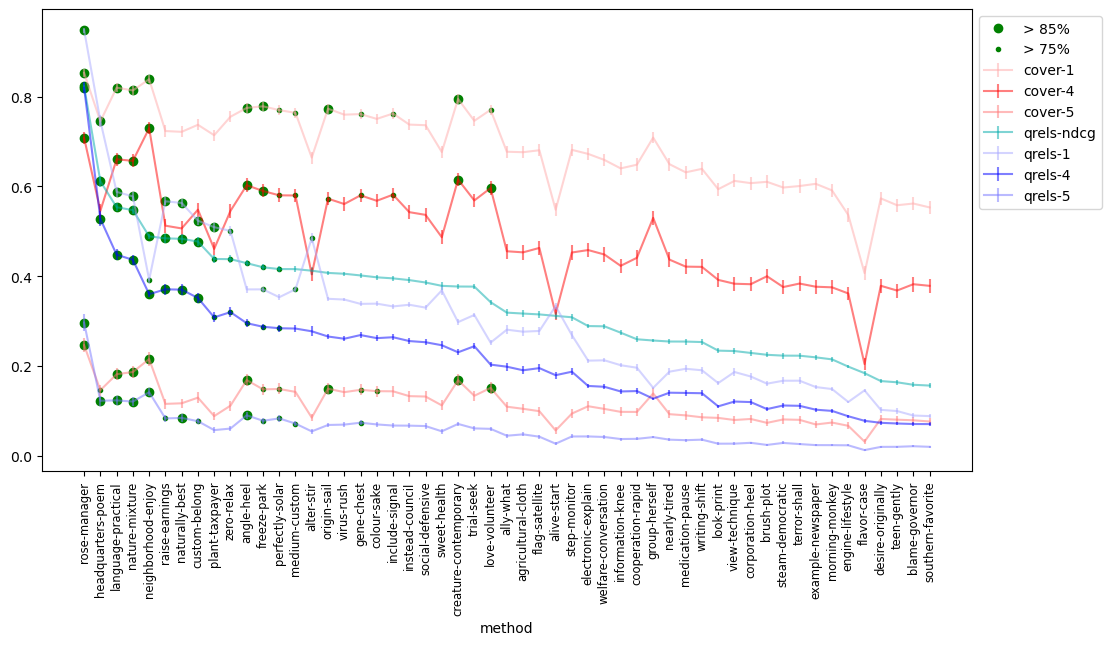

In [32]:
# Plot sorted by qrels-ndcg
fig, plot_file1, plot_file2, plot_file3 = plot_leaderboard(leaderboard_df, "")

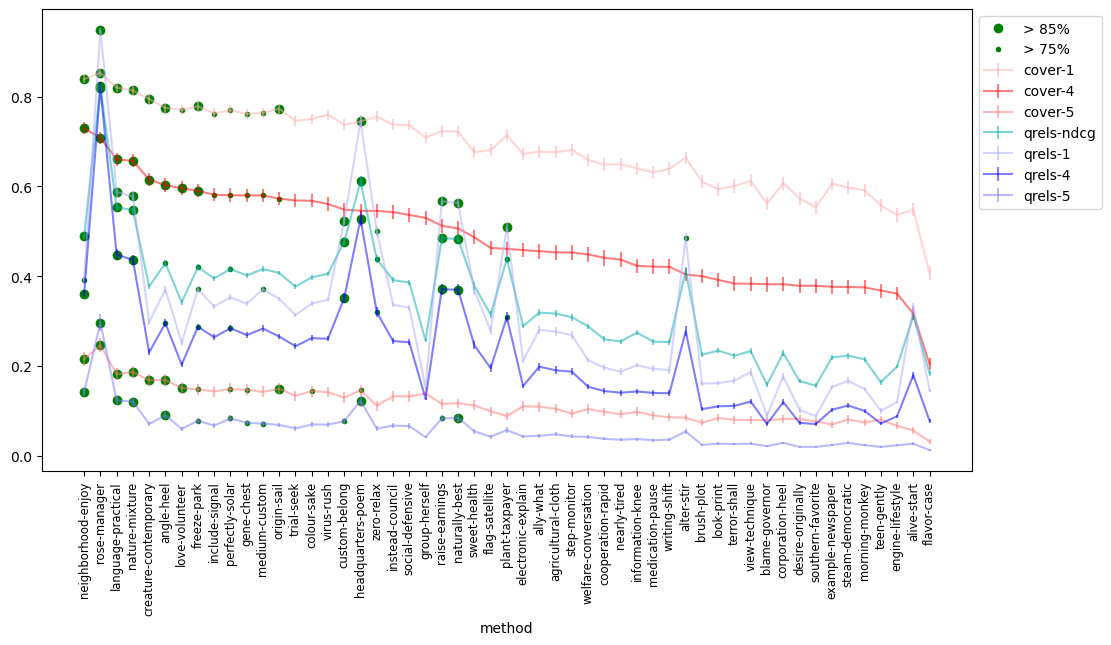

In [33]:
# Plot sorted by cover-4
fig, plot_file1x, plot_file2x, plot_file3x = plot_leaderboard(leaderboard_df_cover, "-cover4")

In [34]:
archive

PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.results.tar.gz')

In [35]:
# produce an archive of RUBRIC analysis result files for distribution

import subprocess

readme = DATA/"README.mkd"
subprocess.run(["tar","-czf",archive, runs,qrels, export_file, all_leaderboard_file, plot_file1, plot_file2, plot_file3, plot_file1x, plot_file2x, plot_file3x, readme])

CompletedProcess(args=['tar', '-czf', PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.results.tar.gz'), PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl-runs'), PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.qrel'), PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.export.tsv'), PosixPath('data/questions-rate--rubric-rag24-auggen.jsonl.leaderboard.tsv'), PosixPath('data/questions-rate--rubric-rag24-auggen.leaderboard-plot.png'), PosixPath('data/questions-rate--rubric-rag24-auggen.leaderboard-plot.svg'), PosixPath('data/questions-rate--rubric-rag24-auggen.leaderboard-plot.pdf'), PosixPath('data/questions-rate--rubric-rag24-auggen.leaderboard-plot-cover4.png'), PosixPath('data/questions-rate--rubric-rag24-auggen.leaderboard-plot-cover4.svg'), PosixPath('data/questions-rate--rubric-rag24-auggen.leaderboard-plot-cover4.pdf'), PosixPath('data/README.mkd')], returncode=0)

# Analysis of Individual Systems

You can skip this section.

Choose queries (topics) and systems (runs) and display the retrieved/generated passages with positively graded rubric-questions.

In [36]:
div_method1="neighborhood-enjoy"
query_id="2024-105741"
minlevel=4

# inspect results
for result in examgrades[0:1]: # just first query
  if result.queryId==query_id:  # a particular query
    queryId=result.queryId
    paragraphs=result.paragraphs
    print(f"query = {result.queryId} / run = {div_method1}")

    correctly_answered=set()
    for paragraph in paragraphs:  # just first ten paragraphs
        paragraph_id = paragraph.paragraph_id
        text = paragraph.text
        rankings = paragraph.paragraph_data.rankings if paragraph.paragraph_data else [] # which system retrieved this paragraph?

        method1_rankings=[ r for r in rankings if r.method==div_method1 ]
        if (method1_rankings):
            rank = method1_rankings[0].rank
            if rank <= 20:
                print("\n")
                print("rank", rank)
                # print(paragraph_id)
                print(text)
                for grades in paragraph.exam_grades:
                    # self_ratings are the numerical grade (0-5) for each question-style nugget
                    # answers are the raw output we received from the grading LLM
                    for index, (r, a) in enumerate(zip(grades.self_ratings, grades.answers)): 
                        if r.self_rating >= minlevel:
                            print(f"Q{index+1}({r.self_rating})")
                            correctly_answered.add(f"Q{index+1}")
                            # print(index, r.question_id, r.self_rating)
                    print("-")
    print(f"correctly answered: {correctly_answered}")        

query = 2024-105741 / run = neighborhood-enjoy


rank 1
A white blood cell count over 15,000 is often indicative of an infection, which can be concerning. It's important to follow up with your doctor, as elevated WBCs can suggest ongoing infection or other health issues. Symptoms like hot flashes, sore joints, fatigue, and swollen lymph nodes further stress the need for medical evaluation and appropriate treatment.
Q3(4)
Q5(4)
Q6(4)
Q7(4)
Q9(4)
-


rank 2
A white blood cell (WBC) count over 15,000 can indicate an infection, as it is often a sign of the body's immune response. This condition, known as leukocytosis, is common in cases of infection and may not be immediately dangerous. However, it's essential to follow up with your doctor, as the underlying cause should be evaluated and treated accordingly.
Q3(4)
Q9(4)
-


rank 3
Yes, having a WBC count over 15,000 can be dangerous if left untreated, as it may indicate an underlying condition that could affect your immune system and lead 